# Objective

### To predict Nino3.4 indices (*represented in Kelvin (K)*) with the help of sea surface temperatures (*represented in Kelvin (K)*).


## Introduction
ENSO stands for the El Niño-Southern Oscillation, a complex climate pattern resulting from variations in ocean temperatures in the Equatorial Pacific. ENSO has three phases: El Niño, La Niña, and Neutral. It significantly influences global weather patterns, temperature, and precipitation, making it crucial for understanding climate variability, disaster preparedness, agriculture, and ecosystem health.
<br>
<br>
Measuring the El Niño-Southern Oscillation (ENSO) involves monitoring various oceanic and atmospheric indicators. Primary methods to measure it includes:
- Sea Surface Temperatures (SST)
- Oceanic Nino Index (ONI)
- Equatorial Pacific Ocean Profiles
- Wind Patterns
- Precipitation Patterns
- Climate Models

This study uses **Sea Surface Temperatures (SST)** to evaluate the Nino3.4 Index which is a metric to quantify ENSO and is discussed later. SST is one of the most critical indicators of ENSO. It is measured using satellite remote sensing, buoys, and ship-based measurements.

<br>
<br>
Various organizations, such as NOAA, NASA, and the European Centre for Medium-Range Weather Forecasts (ECMWF), provide ENSO-related data in NetCDF4 format.
NetCDF4 allows for the storage of large and complex datasets as multidimensional arrays (e.g., time, latitude, longitude, depth).
It provides efficient access to subsets of data without needing to read the entire file, making it suitable for analyzing large datasets, such as global climate model outputs or satellite observations related to ENSO.

<br>
<br>
This study uses [Cobe Sea-Surface Temperature Dataset:](https://psl.noaa.gov/data/gridded/data.cobe.html): this is a dataset of historical sea surface temperatures form 1880 to 2018.




In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm


from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import scipy.stats
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [2]:
# !pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.6 MB/s eta 0:00:00


In [4]:
# loading dataset
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt
!gdown --id 1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t #Nino3.4 index
!gdown 1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc #sst observations from 1880 to 2018

--2024-10-31 15:02:06--  http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.109, 128.55.206.107, 128.55.206.111, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.109|:80... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc [following]
--2024-10-31 15:02:06--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432481041 (412M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.trefadj.anom.1880to2018.nc’

sst.mon.mean.trefad 100%[===================>] 412.45M   140MB/s    in 3.0s    

2024-10-31 15:02:09 (140 MB/s) - ‘sst.mon.mean.trefadj.anom.1880to2018.nc’ sa

#### Creating some important functions that can be used later on.

In [5]:
def load_enso_indices():
  with open('nino34.long.anom.data.txt') as f:
    line = f.readlines()
    enso_values = []

    for l in line :
      yearly_enso_values = map(float, l.split()[1:])
      enso_values.extend(yearly_enso_values)

  enso_values = pd.Series(enso_values)
  enso_values.index = pd.date_range("1870-01-01", freq = "MS", periods = len(enso_values))
  return enso_values



def assemble_basic_predictors_predictands(start_date, end_date,lead_time,use_pca = False, n_components = 32):
  ds = xr.open_dataset("sst.mon.mean.trefadj.anom.1880to2018.nc")

  # getting the dataset from start_date, till the end_date
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]

  # reshaping
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0


  # for dimension reduction
  if use_pca:
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(sst)
    X = pca.transform(sst)
  else:
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead,
                                end_date_plus_lead)]
  ds.close()

  return X,y

# plotting nino time series
def plot_nino_time_series(y, predictions,title):
  predictions = pd.Series(predictions, index = y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()


Lead time refers to the period between the initiation of an ENSO event (either El Niño or La Niña) and the time when the impacts of that event are expected to be observed. Lead time is crucial for understanding and predicting the effects of ENSO on global and regional weather patterns, including precipitation, temperature anomalies, and extreme weather events.
- **Short Lead Times**: Predictions with shorter lead times (1-3 months) are generally more reliable. These forecasts can inform immediate agricultural decisions, water management, and disaster preparedness.
- **Long Lead Times**: Longer lead times (6-12 months) are useful for strategic planning, such as long-term agricultural planning, infrastructure development, and climate adaptation strategies. However, they come with greater uncertainty.
###Training data
Training on 1980-1995 sea Surface temperatures and their corresponding Nino3.4 Index at lead times (1 month to 5 months)
###Validation data
1997-2006 sea surface temperatures and their corresponding Nino3.4 Index at lead times.

###Testing data
Test on 2007-2017 sea surface temperatures and their corresponding Nino3.4 Index at lead times (1 month to 5 month).

In [6]:
# Sample of train, val, and test sets
X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=1)
X_val, y_val = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=1)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01','2017-12-31', lead_time=1)

### Simple Linear Regression Model (Base Model)

Firstly, we will start with simple linear regression model.
<br>
The metrics that will be used to evaluate the model : RMSE (Root Mean Square Error) and Pearson's correlation.

RMSE: 0.28


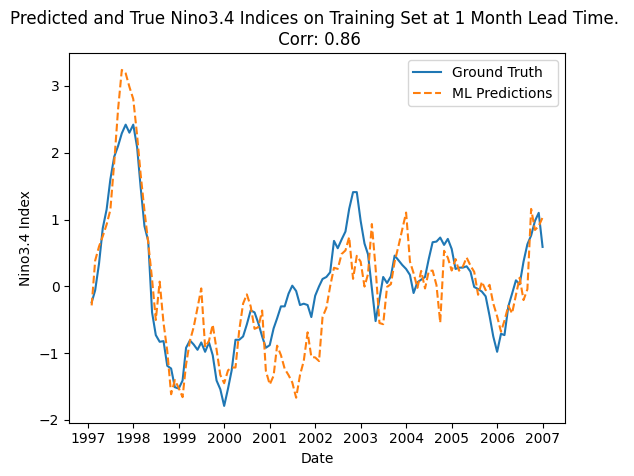

In [7]:
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions = regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(predictions, y_val)
rmse = mean_squared_error(y_val, predictions)
print("RMSE: {:.2f}".format(rmse))

plot_nino_time_series(y_val, predictions,
    'Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time. \n Corr: {:.2f}'.format(corr))

the atmosphere usually has a "memory" of about 14 days, and the ocean roughly has a "memory" of about 2 years.
If we randomly split the dataset into train set and test set, some of the examples in the test set will be correlated with examples in the train set. This corrupts our test set. If the test set is correlated with the train set, then it no longer measures how generalizable our ML model is.

### Linear Regression with Ridge Regularization

RMSE: 0.19


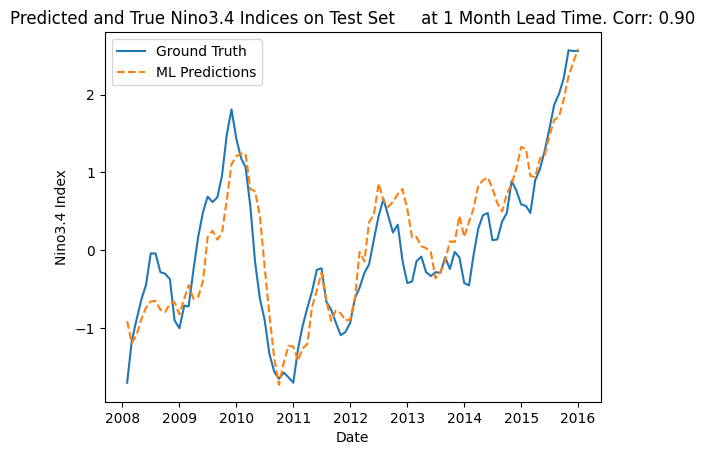

In [11]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31',
                                                1,use_pca=True)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_ridge = sklearn.linear_model.Ridge(alpha=7000.0)
regr_1_month_ridge.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_ridge.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
rmse = mean_squared_error(y_test, predictions_test)
print("RMSE: {:.2f}".format(rmse))

plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))

Regularized model performs slightly better than the linear model.